# This script compares the exponent and knee parameters between sleep stages in the iEEG data and runs correlations between them

## Libraries

In [2]:
import os
from pathlib import Path
import numpy as np
import mne
from scipy import stats
import pandas as pd
import random
import pickle
from pandas.plotting import table 
from cliffs_delta import cliffs_delta 
from pingouin import partial_corr

# Plotting functions
from spiketools.plts.utils import make_axes
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 

# Import custom made code
import sys
sys.path.append("/home/b1044271/Columbia/Aperiodic_sleep/helpers")
from utils import check_distribution, perform_correlation, compute_z_values, bonferroni_correction, friedman_dunns, perform_permutation_test

import warnings
warnings.filterwarnings("ignore")

## Paths and Load data

In [3]:
save_path = '/home/b1044271/Columbia/Results/2025/iEEG_results.pkl'

with open(save_path, 'rb') as f:
    loaded_data = pickle.load(f)
    PSDs_W = loaded_data['PSDs']['Wakefulness']
    PSDs_N2 = loaded_data['PSDs']['N2']
    PSDs_N3 = loaded_data['PSDs']['N3']
    PSDs_R = loaded_data['PSDs']['REM']
    param_data = loaded_data['param_data']

## Extract R2, Exponent & Knee term - Knee M

In [4]:
# Exponent
W_ExpK = param_data["Wakefulness"]["Exp"]
N2_ExpK = param_data["N2"]["Exp"]
N3_ExpK = param_data["N3"]["Exp"]
R_ExpK = param_data["REM"]["Exp"]

# KNee Frequency
W_Knee = param_data["Wakefulness"]["Kn"]
N2_Knee = param_data["N2"]["Kn"]
N3_Knee = param_data["N3"]["Kn"]
R_Knee = param_data["REM"]["Kn"]

# R2
W_R2K = param_data["Wakefulness"]["R2K"]
N2_R2K = param_data["N2"]["R2K"]
N3_R2K = param_data["N3"]["R2K"]
R_R2K = param_data["REM"]["R2K"]

## Extract R2, Exponent of Fixed Model

In [5]:
# Exponent
W_ExpF = param_data["Wakefulness"]["Exp2"]
N2_ExpF = param_data["N2"]["Exp2"]
N3_ExpF = param_data["N3"]["Exp2"]
R_ExpF = param_data["REM"]["Exp2"]

# R2
W_R2F = param_data["Wakefulness"]["R2N"]
N2_R2F = param_data["N2"]["R2N"]
N3_R2F = param_data["N3"]["R2N"]
R_R2F = param_data["REM"]["R2N"]

## Organize the Arrays for Plotting

In [8]:
# Knee Array
array_list2 = [np.nanmean(W_Knee,1), np.nanmean(N2_Knee,1), np.nanmean(N3_Knee,1), np.nanmean(R_Knee,1)]

# Exponent of Knee Model
array_list3 = [np.nanmean(W_ExpK,1), np.nanmean(N2_ExpK,1), np.nanmean(N3_ExpK,1), np.nanmean(R_ExpK,1)]

# Exponent of Fixed Model
array_list4 = [np.nanmean(W_ExpF,1), np.nanmean(N2_ExpF,1), np.nanmean(N3_ExpF,1), np.nanmean(R_ExpF,1)]

# R2 of Knee Model
array_list5 = [np.nanmean(W_R2K,1), np.nanmean(N2_R2K,1), np.nanmean(N3_R2K,1), np.nanmean(R_R2K,1)]


array_list6 = [np.nanmean(W_R2F,1), np.nanmean(N2_R2F,1), np.nanmean(N3_R2F,1), np.nanmean(R_R2F,1)]

## Plot change in Parameters across Stages

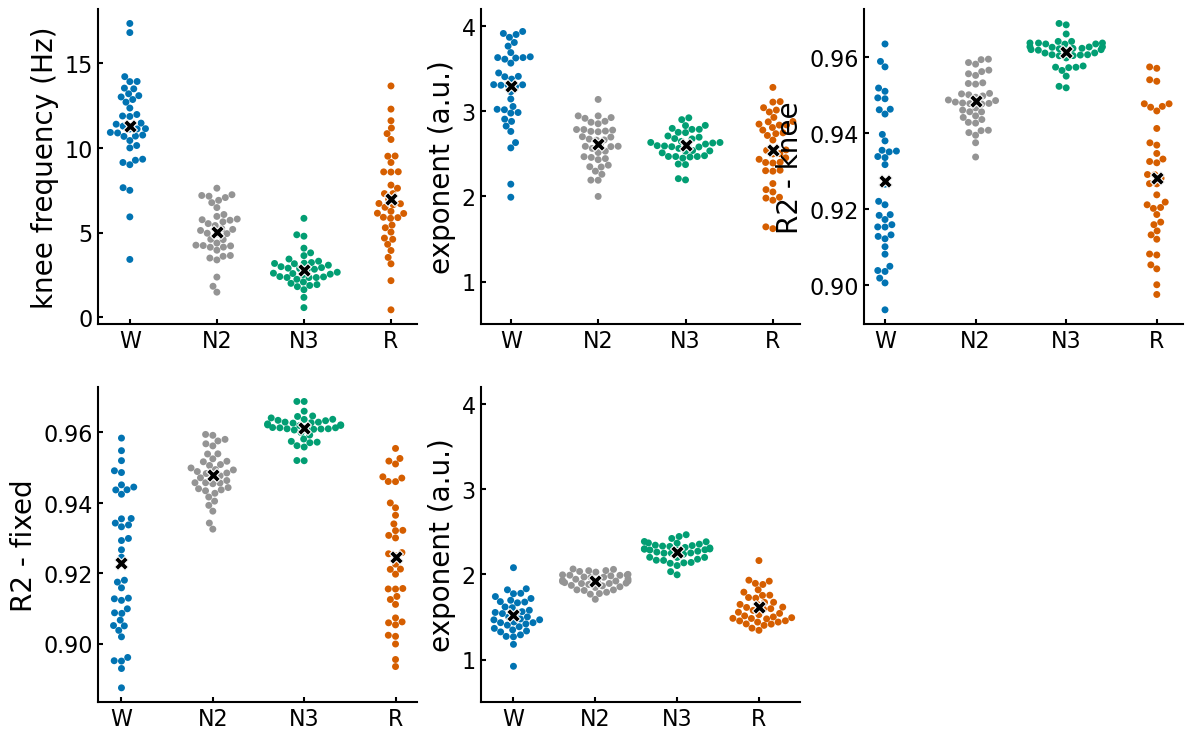

In [16]:
arrays = [array_list2, array_list3, array_list5, array_list6, array_list4]

ColStage = [sns.color_palette("colorblind")[0], sns.color_palette("colorblind")[7], 
        sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[3]]

titles =  ['W','N2','N3','R']
y_label = ['knee frequency (Hz)' , 'exponent (a.u.)' , 'R2 - knee', 'R2 - fixed', 'exponent (a.u.)']
fig = plt.figure(figsize=(14, 9))  
#sns.set_theme(style='white')
sns.color_palette()

for i, V in enumerate(arrays):

    ax = fig.add_subplot(2, 3, i+1)

    ax = sns.swarmplot(data=V, palette = ColStage)
    plt.ylabel(y_label[i], fontsize = 20)
    ax.set_xticklabels(titles, fontsize = 20)
    sns.scatterplot(x=[0,1,2,3], y=np.mean(V,1), marker='X', color='black', s=100, zorder=4, legend=False)
    #plt.plot([V[0], V[1], V[2], V[3]], color = 'grey', linewidth = 0.25, linestyle = '-')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    if i == 1 or i == 4:
        plt.ylim(0.5,4.2)
    
    if i == 4:
        plt.xlim(-0.40,3.5)   
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='in', width=1.5, labelsize=16)  # Customize tick properties
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    
plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_slope_knee_points.svg", dpi = 600)

# Now Run the STATS

#### Diff in Knee Freq across Stages

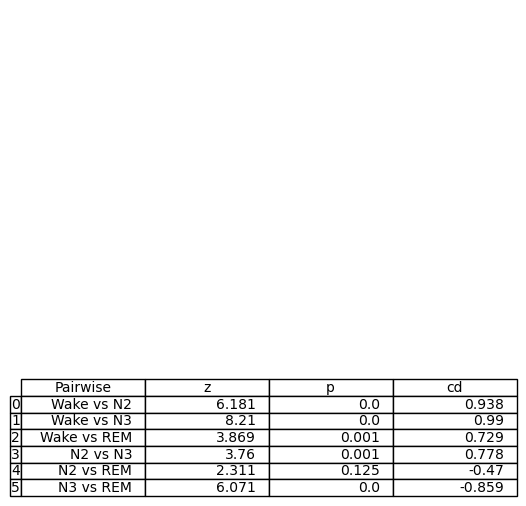

In [17]:
# KNEE - STATS
data = pd.DataFrame(np.transpose(array_list2))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]

# MAKE STAT TABLE
#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,6,7,11] 
x3 = x2[idx]

y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE    
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)
stat_df.style.set_properties(**{'text-align': 'centre'})

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Stats_iEEG_KneeFreq_STATS.svg')

### Difference in Exponent of Knee across stages

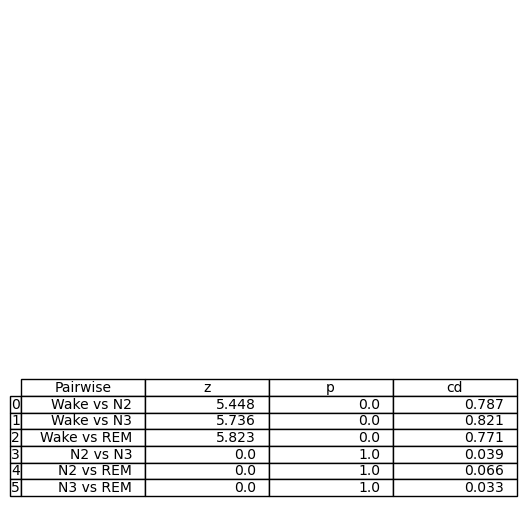

In [18]:
# EXP_K - STATS
data = pd.DataFrame(np.transpose(array_list3))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

z_values2 = compute_z_values(corrected_p_values)

effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]

# MAKE STAT TABLE

#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,6,7,11] 
x3 = x2[idx]


y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values2.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE    
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)
stat_df.style.set_properties(**{'text-align': 'centre'})

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Stats_iEEG_ExpKnee_STATS.svg')

### Difference in Exp of Fixed Model

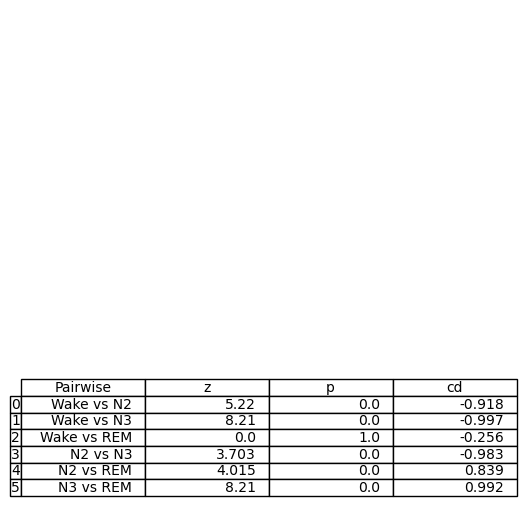

In [19]:
# EXP_Fixed - STATS
data = pd.DataFrame(np.transpose(array_list4))

friedman_result, W, posthoc_result, z_values, effect_sizes, corrected_p_values = friedman_dunns(data)

z_values2 = compute_z_values(corrected_p_values)

effect_sizes2 = pd.DataFrame(index=data.columns, columns=data.columns)
for i, col1 in enumerate(data.columns):
    for j, col2 in enumerate(data.columns):
        if i < j:
            effect_sizes2.loc[col1, col2] = cliffs_delta(data[col1], data[col2])[0]
            effect_sizes2.loc[col2, col1] = -effect_sizes2.loc[col1, col2]

# MAKE STAT TABLE

#add the relevant pairwise comaprisons
x = pd.DataFrame.to_numpy(corrected_p_values)
x2 = x.reshape(len(x)*len(x))
idx = [1,2,3,6,7,11] 
x3 = x2[idx]


y = pd.DataFrame.to_numpy(effect_sizes2)
y2 = y.reshape(len(y)*len(y))
y3 = y2[idx]
y3 = y3.astype(float)

z2 = z_values2.reshape(len(z_values)*len(z_values))
z3 = z2[idx]

# create an array with the names of the pairwise comparisons
pairwise_tests = ['Wake vs N2', 'Wake vs N3', 'Wake vs REM',  # WAKE    
                          'N2 vs N3' , 'N2 vs REM',   # N2
                       'N3 vs REM']  # REM

# create dataframe
data = {'Pairwise' : pairwise_tests,'z' : np.round(z3,3),'p' : np.round(x3,3),'cd' : np.round(y3,3)}

stat_df = pd.DataFrame(data)
stat_df.style.set_properties(**{'text-align': 'centre'})

# PLOTTING the table
ax = plt.subplot(111, frame_on=False) # no visible frame
table(ax, stat_df)  # where df is your data frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
plt.savefig('/home/b1044271/Columbia/Plots/NOV24/Stats_iEEG_ExpFixed_STATS.svg')

## Correlations between Knee and Exponent

In [9]:
#adjust arrays
Set_Knee= np.squeeze(np.reshape(array_list2, (1,38*4)))
Set_ExpF = np.squeeze(np.reshape(array_list4, (1,38*4)))
Set_ExpK = np.squeeze(np.reshape(array_list3, (1,38*4)))

#make a dataframe
data = {'Knee' : Set_Knee,
       'Exp_knee' : Set_ExpK,
       'Exp_fixed' : Set_ExpF,
       'Stages' : np.repeat(['W','N2','N3','R'], 38, axis=0)}

df = pd.DataFrame(data)

# Convert categorical "Stages" column into numeric codes
df["Stages_numeric"] = df["Stages"].astype("category").cat.codes

### A) Calculate and Plot correlation (Knee Freq and Exponent of FIXED MODEL)

In [26]:
perform_correlation(Set_Knee,Set_ExpF)

# Partial correlations
partial_corr_result = partial_corr(data=df, x="Knee", y="Exp_fixed", covar="Stages_numeric", method="spearman")
partial_corr_result

Using Spearman correlation
Correlation: -0.7888825101319719
P-value: 1.5754095786753996e-33


,n,r,CI95%,p-val
spearman,152,-0.642098,"[-0.73, -0.54]",6.392583e-19


<Figure size 300x600 with 0 Axes>

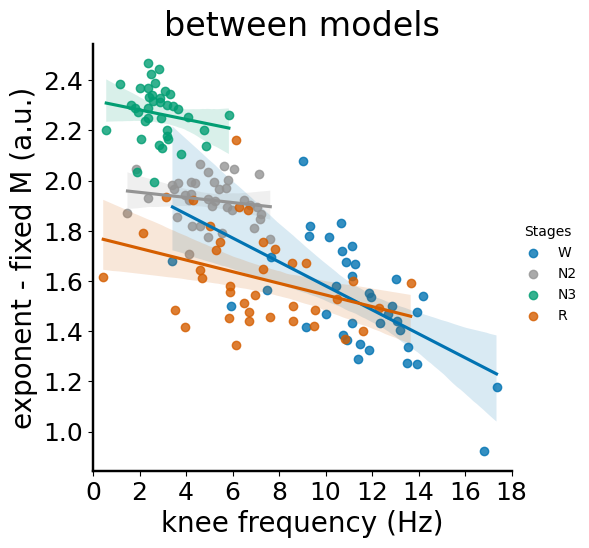

In [27]:
# PLOT correlations between Models 
plt.figure(figsize=(3,6))  
sns.lmplot(x="Knee", y="Exp_fixed", hue="Stages", data=df, palette = ColStage);

ax=plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent - fixed M (a.u.)',fontsize=20)
plt.xlabel('knee frequency (Hz)',fontsize=20)
plt.title('between models', fontsize = 24)
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)
plt.xlim(0,18)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Correlations_FixedM.svg", dpi = 600)

### B) Correlation Between Knee Freq and Exponent of Knee Model

In [24]:
perform_correlation(Set_Knee,Set_ExpK)

# Partial Correlations
partial_corr_result = partial_corr(data=df, x="Knee", y="Exp_knee", covar="Stages_numeric", method="spearman")
partial_corr_result

Using Spearman correlation
Correlation: 0.7058686841763543
P-value: 3.1486878142015473e-24


,n,r,CI95%,p-val
pearson,152,0.649589,"[0.55, 0.73]",1.834959e-19


### Plot the correlations

<Figure size 300x400 with 0 Axes>

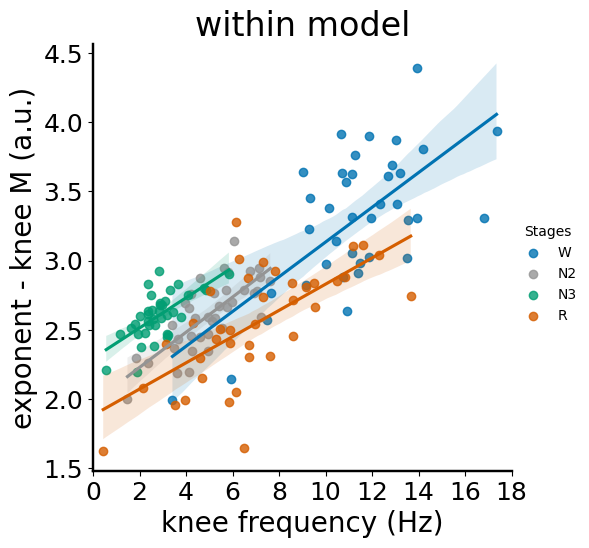

In [26]:
plt.figure(figsize=(3,4))  

sns.lmplot(x="Knee", y="Exp_knee", hue="Stages", data=df, palette = ColStage);

ax=plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent - knee M (a.u.)',fontsize=20)
plt.xlabel('knee frequency (Hz)',fontsize=20)
plt.title('within model', fontsize = 24)
plt.xlim(0,18)
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Correlations_KneeM.svg", dpi = 600)

## 3. Exponent_Knee vs Exponent_Fixed corrrelations

In [27]:
perform_correlation(Set_ExpF, Set_ExpK)

# Compute partial correlation controlling for "Stages_numeric"
partial_corr_result = partial_corr(data=df, x="Exp_fixed", y="Exp_knee", covar="Stages_numeric", method="spearman")
print(partial_corr_result)

Using Spearman correlation
Correlation: -0.23442956827206307
P-value: 0.0036490685099718192
            n         r          CI95%     p-val
spearman  152  0.076524  [-0.08, 0.23]  0.350354


<Figure size 300x400 with 0 Axes>

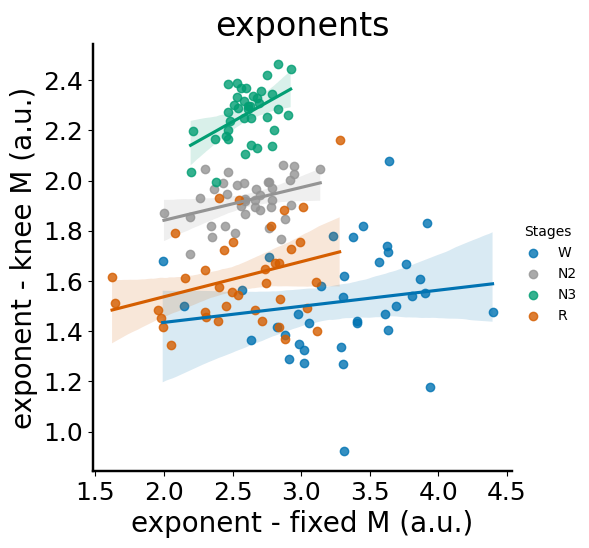

In [35]:
plt.figure(figsize=(3,4))  

sns.lmplot(x="Exp_knee", y="Exp_fixed", hue="Stages", data=df, palette = ColStage);

ax=plt.gca()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('exponent - knee M (a.u.)',fontsize=20)
plt.xlabel('exponent - fixed M (a.u.)',fontsize=20)
plt.title('exponents', fontsize = 24)
ax.spines['bottom'].set_linewidth(1.75)
ax.spines['left'].set_linewidth(1.75)

plt.savefig("/home/b1044271/Columbia/Plots/NOV24/iEEG_Correlations_Exps.svg", dpi = 600)